In [1]:
import warnings
warnings.filterwarnings('ignore')

import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from itertools import product
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from IPython.display import display

%matplotlib inline

In [2]:
# Helper functions

def rmse(*args):
    return np.sqrt(mean_squared_error(*args))

def downcast_dtypes(df):
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
sales = pd.read_csv('competition_data/sales_train_v2.csv')
shops = pd.read_csv('competition_data/shops.csv')
items = pd.read_csv('competition_data/items.csv')
item_cats = pd.read_csv('competition_data/item_categories.csv')
test_data = pd.read_csv('competition_data/test.csv')

In [4]:
display(sales.head())
display(shops.head())
display(items.head())
display(item_cats.head())
display(test_data.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# EDA


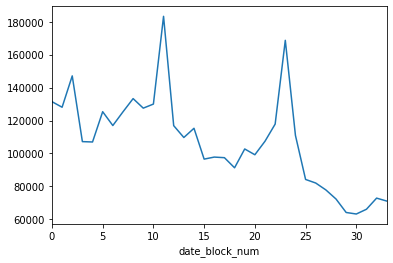

In [5]:
# Visualization of the selling trend (we can see spikes during christmas but overall lowering trend of buying)
sales.groupby(['date_block_num']).sum()['item_cnt_day'].plot()

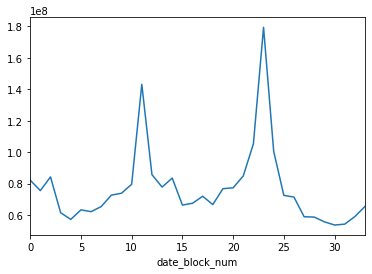

In [6]:
# Similar pattern for prices can be seen here
sales.groupby(['date_block_num']).sum()['item_price'].plot()

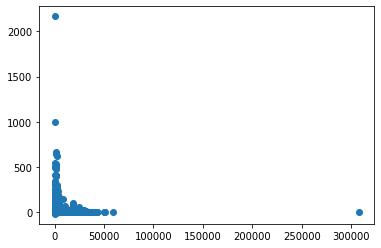

In [7]:
# There appears to be some outliers in the data
plt.scatter(sales['item_price'], sales['item_cnt_day'])

In [8]:
outlier_item_cnt_day = sales.item_cnt_day.max()
outlier_item_price = sales.item_price.max()
print(outlier_item_cnt_day)
print(outlier_item_price)

2169.0
307980.0


# Data leak

In [9]:
train_ids = sales.drop_duplicates(['shop_id', 'item_id'])[['shop_id', 'item_id']]
test_ids = test_data.drop_duplicates(['shop_id', 'item_id'])[['shop_id', 'item_id']]
train_ids = {(shop, item) for shop, item in train_ids.values}
test_ids = {(shop, item) for shop, item in test_ids.values}

In [10]:
print('Unique shop-item id combinations in train set {}'.format(len(train_ids)))
print('Unique shop-item id combinations in test set {}'.format(len(test_ids)))
print('Intersection of shop-item ids in both train and test {}'.format(len(train_ids.intersection(test_ids))))
print('New shop-item id combination for which we don\'t have labels {}'.format(len(test_ids - train_ids)))

Unique shop-item id combinations in train set 424124
Unique shop-item id combinations in test set 214200
Intersection of shop-item ids in both train and test 111404
New shop-item id combination for which we don't have labels 102796


# Feature Engineering

In [11]:
# Columns used for merging
index_cols = ['shop_id', 'item_id', 'date_block_num']

# Exploiting data leak (we're only interested in item ids that are in both test and train sets)
sales = sales[sales.item_id.isin(test_data.item_id)]

# For every month we create a matrix from all shops/items combinations from that month
matrix = [] 
new_items = pd.DataFrame()
cur_items_aux=np.array([])
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
    cur_items_aux = cur_items[pd.Series(cur_items).isin(test_data.item_id)]
    matrix.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Convert matrix into a dataframe
matrix = pd.DataFrame(np.vstack(matrix), columns = index_cols,dtype=np.int32)

# Add test data that represents following month (34) to our matrix 
test_data['date_block_num'] = 34
matrix = matrix.append(test_data[['shop_id', 'item_id', 'date_block_num']])

# Add target column to our accumulated data (amount if items sold by specific shop in the specific month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
all_data = pd.merge(matrix, gb, how='left', on=index_cols).fillna(0)

# Add target shop column that represents specific shop monthly sales
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Add target item column that represents how many times specific item was sold in specific month
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Convert all 64 bit data types to 32 bit in order to decrease memory usage
all_data = downcast_dtypes(all_data)
del matrix, gb 
gc.collect()
 
# Here we create a set of powerful features -> lags (values of specific columns back in time e.g. lag 1 = value that was here previous month)

# We go back 3 month at max
lag_range = [1, 2, 3]

# List of columns used for lags
cols_to_rename = list(all_data.columns.difference(index_cols))

for month_lag in tqdm(lag_range):
    train_lag = all_data[index_cols + cols_to_rename].copy()
    train_lag['date_block_num'] = train_lag['date_block_num'] + month_lag
    fun = lambda x: '{}_lag_{}'.format(x, month_lag) if x in cols_to_rename else x
    train_lag = train_lag.rename(columns=fun)
    all_data = pd.merge(all_data, train_lag, on=index_cols, how='left').fillna(0)

del train_lag

# We won't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in lag_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [12]:
# Mean encoded features

mean_encoded_item_cats = pd.DataFrame(all_data.groupby(['shop_id','item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_encoded_item_cats.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']
all_data = pd.merge(all_data, mean_encoded_item_cats, how='left', on=['shop_id', 'item_category_id'])

del mean_encoded_item_cats
all_data = downcast_dtypes(all_data)

In [13]:
# Train test split (last month is test)
train = all_data[all_data.date_block_num  < 34].fillna(0)
test  = all_data[all_data.date_block_num == 34].fillna(0)
train.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37,0.512281,2.742767
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40,1.120868,10.631319
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37,0.512281,2.742767
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40,1.120868,10.631319
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55,0.902726,2.715576


In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,3110574.0,31.901944,17.323508,2.0,17.000000,33.000000,47.000000,59.000000
item_id,3110574.0,10818.201138,6275.575794,30.0,5095.000000,10785.000000,16090.000000,22167.000000
date_block_num,3110574.0,24.035516,6.103539,12.0,19.000000,25.000000,29.000000,33.000000
target,3110574.0,0.453473,4.450819,-2.0,0.000000,0.000000,0.000000,2253.000000
target_shop,3110574.0,1396.751343,1123.326294,-1.0,763.000000,1062.000000,1491.000000,10495.000000
target_item,3110574.0,21.487192,131.944809,-1.0,1.000000,6.000000,16.000000,12185.000000
target_lag_1,3110574.0,0.454072,4.483642,-2.0,0.000000,0.000000,0.000000,1305.000000
target_item_lag_1,3110574.0,21.430510,139.486404,-1.0,1.000000,5.000000,16.000000,12557.000000
target_shop_lag_1,3110574.0,1325.843018,1137.565918,0.0,705.000000,1034.000000,1459.000000,10495.000000
target_lag_2,3110574.0,0.447597,4.587493,-4.0,0.000000,0.000000,0.000000,1305.000000


# Train / Val / Test - split

In [15]:
dates = train['date_block_num']
boolean_test = (dates.isin([30,31,32,33]))
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = train.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  train.loc[boolean_test].drop(to_drop_cols, axis=1)
X_test = test.drop(to_drop_cols, axis=1)

y_train = train.loc[boolean_train, 'target'].values
y_val =  train.loc[boolean_test, 'target'].values
y_test = test['target'].values

X = X_train.append(X_val)
y = np.append(y_train, y_val)

# Optimization and training of models (skip this part because it takes long time to train)

In [18]:
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
best_rmse = np.inf

for lr in tqdm(learning_rates):
    
    xgb_model = XGBRegressor(
        n_jobs=8,
        learning_rate=lr,
        max_depth=10,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=1)

    xgb_model.fit(
        X_train, 
        y_train.clip(0,20), 
        eval_metric="rmse", 
        eval_set=[(X_train, y_train.clip(0,20)), (X_val, y_val.clip(0,20))], 
        verbose=False, 
        early_stopping_rounds=2)
    
    pred_xgb_val = xgb_model.predict(X_val)
    score = rmse(y_val.clip(0,20), pred_xgb_val.clip(0,20))
    
    if score < best_rmse:
        best_rmse = score
        best_lr = lr
        print('{} is best learning rate so far...'.format(best_lr))
    
# 0.08 was the best learning rate

[19:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.01 is best learning rate so far...
[19:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.02 is best learning rate so far...
[19:50:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.03 is best learning rate so far...
[19:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
xgb_model = XGBRegressor(
        n_jobs=8,
        learning_rate=best_lr,
        max_depth=10,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=1)

xgb_model.fit(
    X, 
    y.clip(0,20), 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train.clip(0,20)), (X_val, y_val.clip(0,20))], 
    verbose=50, 
    early_stopping_rounds=20)

[20:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.43379	validation_1-rmse:1.26249
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[50]	validation_0-rmse:0.955189	validation_1-rmse:0.877937
[100]	validation_0-rmse:0.942633	validation_1-rmse:0.871878
[150]	validation_0-rmse:0.930875	validation_1-rmse:0.863868
[200]	validation_0-rmse:0.921702	validation_1-rmse:0.858302
[250]	validation_0-rmse:0.916851	validation_1-rmse:0.854932
[300]	validation_0-rmse:0.909318	validation_1-rmse:0.849604
[350]	validation_0-rmse:0.9047	validation_1-rmse:0.846098
[400]	validation_0-rmse:0.89872	validation_1-rmse:0.84102
[450]	validation_0-rmse:0.893365	validation_1-rmse:0.836074
[500]	validation_0-rmse:0.888856	validation_1-rmse:0.832113
[550]	validation_0-rmse:0.885504	validation_1-rmse:0.829684
[60

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=300, missing=None,
             n_estimators=1000, n_jobs=8, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, silent=None, subsample=0.8, verbosity=1)

In [22]:
rf_model = RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=8,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
rf_model.fit(X, y.clip(0,20))

In [24]:
# Save the models
#pickle.dump(xgb_model, open('models/xgb_model.pkl', 'wb'))
#pickle.dump(rf_model, open('models/rf_model.pkl', 'wb'))

# Testing the models (continue here)

In [16]:
# Load the models
xgb_model = pickle.load(open('models/xgb_model.pkl', 'rb'))
rf_model = pickle.load(open('models/rf_model.pkl', 'rb'))

[17:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
xgb_predict_train = xgb_model.predict(X_train)
xgb_predict_val = xgb_model.predict(X_val)
print('Train RMSE for XGB is {}'.format(rmse(y_train.clip(0,20), xgb_predict_train.clip(0,20))))
print('Val RMSE for XGB is {}'.format(rmse(y_val.clip(0,20), xgb_predict_val.clip(0,20))))

Train RMSE for XGB is 0.8797357082366943
Val RMSE for XGB is 0.7452297806739807


In [18]:
rf_predict_train = rf_model.predict(X_train)
rf_predict_val = rf_model.predict(X_val)
print('Train RMSE for Random Forest is {}'.format(rmse(y_train.clip(0,20), rf_predict_train.clip(0,20))))
print('Val RMSE for Random Forest is {}'.format(rmse(y_val.clip(0,20), rf_predict_val.clip(0,20))))

Train RMSE for Random Forest is 0.9624247608720525
Val RMSE for Random Forest is 0.7976568427945554


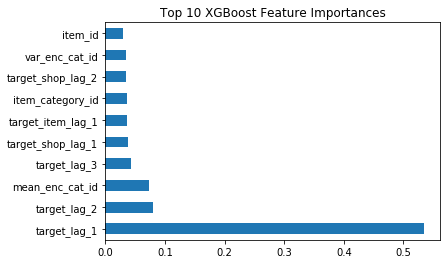

In [19]:
features = pd.Series(xgb_model.feature_importances_, index=X.columns)
features = features.nlargest(10)
features.plot(kind='barh')
plt.title('Top 10 XGBoost Feature Importances')
plt.show()

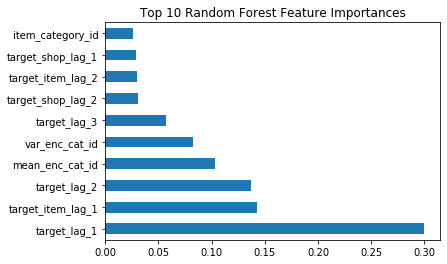

In [20]:
features = pd.Series(rf_model.feature_importances_, index=X.columns)
features = features.nlargest(10)
features.plot(kind='barh')
plt.title('Top 10 Random Forest Feature Importances')
plt.show()

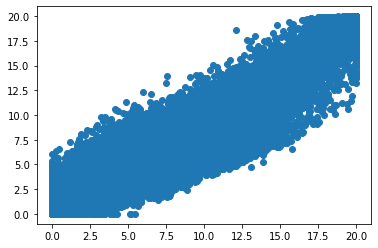

In [21]:
# Check how good are the predictions (nice diagonal pattern with few outliers means very good model predictions)
predictions1 = xgb_model.predict(X)
predictions2 = rf_model.predict(X)
plt.scatter(predictions1.clip(0,20), predictions2.clip(0,20))

# Stacking models

In [22]:
# Train linear model on predictions of random forest and xgboost

lr_model = LinearRegression(n_jobs=8)
xgb_preds = xgb_model.predict(X)
rf_preds = rf_model.predict(X)
X_stacking = np.c_[xgb_preds, rf_preds]
lr_model.fit(X_stacking, y.clip(0,20))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=8, normalize=False)

In [23]:
xgb_train_preds = xgb_model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
X_train_stacking = np.c_[xgb_train_preds, rf_train_preds]
lr_train_preds = lr_model.predict(X_train_stacking)

print('Train RMSE for Stacked linear regression is {}'.format(rmse(y_train.clip(0,20), lr_train_preds.clip(0,20))))

Train RMSE for Stacked linear regression is 0.872346123527145


In [24]:
xgb_val_preds = xgb_model.predict(X_val)
rf_val_preds = rf_model.predict(X_val)
X_val_stacking = np.c_[xgb_val_preds, rf_val_preds]
lr_val_preds = lr_model.predict(X_val_stacking)

print('Val RMSE for Stacked linear regression is {}'.format(rmse(y_val.clip(0,20), lr_val_preds.clip(0,20))))

Val RMSE for Stacked linear regression is 0.740831665590659


In [25]:
xgb_test_preds = xgb_model.predict(X_test)
rf_test_preds = rf_model.predict(X_test)
X_test_stacking = np.c_[xgb_test_preds, rf_test_preds]
test_preds = lr_model.predict(X_test_stacking)

# Creating submission

In [26]:
predictions = pd.DataFrame()
predictions['shop_id'] = test_data.shop_id
predictions['item_id'] = test_data.item_id
predictions['item_cnt_month'] = test_preds
submision = test_data[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('submission.csv',index=False)

On a final note, I would like to thank organizers for creating this insightful and interesting course!